## Notebook 2 : Geographical vizualizations and regional comparisons

## 1 - Introduction ##

Overview of the notebook’s objective and the data used.


In [3]:
#### EXPLORING THE DATASET ####
import pandas as pd

# Read in the data
df_geo = pd.read_csv('df_complete.csv')

df_geo.head()

/var/folders/ql/7rnwb81s5ms8q8f6v8hbbkb00000gn/T/ipykernel_2457/325737377.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_geo = pd.read_csv('df_complete.csv')


,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee
0,2019-01-07 00:00:00.000000000,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019
1,2019-04-07 00:00:00.000000000,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019
2,2019-04-07 00:00:00.000000000,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019
3,2019-04-07 00:00:00.000000000,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019
4,2019-03-07 00:00:00.000000000,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,0.0,0,0.0,0.0,8.0,2019


In [4]:
#### CONVERTS TO THE RIGHT TYPE ####

category_convert = ['Nature mutation', 'Voie', 'Code postal', 'Commune', 'Code departement', 'Code commune', 'Code type local', 'Type local']
df_geo[category_convert] = df_geo[category_convert].astype('category')

df_geo['Date mutation'] = pd.to_datetime(df_geo['Date mutation'], errors = 'coerce')
df_geo['Date mutation'] = df_geo['Date mutation'].interpolate(method='linear')

df_geo['Valeur fonciere']=df_geo['Valeur fonciere'].replace({'\xa0':'',',':'.'}, regex=True)
df_geo['Valeur fonciere']=pd.to_numeric(df_geo['Valeur fonciere'], errors='coerce')

df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17810875 entries, 0 to 17810874
Data columns (total 15 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Date mutation              datetime64[ns]
 1   Nature mutation            category      
 2   Valeur fonciere            float64       
 3   Voie                       category      
 4   Code postal                category      
 5   Commune                    category      
 6   Code departement           category      
 7   Code commune               category      
 8   Nombre de lots             int64         
 9   Code type local            category      
 10  Type local                 category      
 11  Surface reelle bati        float64       
 12  Nombre pieces principales  float64       
 13  Surface terrain            float64       
 14  annee                      int64         
dtypes: category(8), datetime64[ns](1), float64(4), int64(2)
memory usage: 1.2 GB


In [5]:
#### CHECK MISSING VALUES ####
df_geo.isnull().sum()

Date mutation                0
Nature mutation              0
Valeur fonciere              0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Code commune                 0
Nombre de lots               0
Code type local              0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
annee                        0
dtype: int64

In [6]:
#### CHECK DUPLICATES ####
#df_geo.drop_duplicates(keep='last', inplace=True)
df_geo.duplicated().sum()

0

In [7]:
df_geo.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee
0,2019-01-07,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019
1,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019
2,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019
3,2019-04-07,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019
4,2019-03-07,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,0.0,0,0.0,0.0,8.0,2019


## 2 - Methodology ##

Explanation of the analysis methods and visualizations.

Data Exploration:
- Analyze geographical data (communes, departments) and its relationship to property values.
- Study temporal trends in transactions across regions.

In [8]:
#### LIBRARIES ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
import geopandas as gpd
from geopy.exc import GeopyError
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [9]:
#### PRICE PER SQUARE METER ####
df_geo['price_per_sq_meter'] = df_geo['Valeur fonciere'] / df_geo['Surface reelle bati']
df_geo['price_per_sq_meter'] = df_geo['price_per_sq_meter'].round(2)
df_geo.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,price_per_sq_meter
0,2019-01-07,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019,1628.00
1,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019,2074.47
2,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019,2074.47
3,2019-04-07,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019,1222.56
4,2019-03-07,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,0.0,0,0.0,0.0,8.0,2019,inf


In [10]:
#### ANALISYS OF WHEN THERE'S NO BUILD ####
df_no_build = df_geo[df_geo['Surface reelle bati']==0]
mean_no_build = round(df_no_build['Valeur fonciere'].mean(), 2)
median_no_build = round(df_no_build['Valeur fonciere'].median(), 2)

print('No build average price per square meter : ', mean_no_build, '€')
print('No build median price per square meter : ', median_no_build, '€')

df_build = df_geo[df_geo['Surface reelle bati']!=0]
mean_build = round(df_build['Valeur fonciere'].mean(), 2)
median_build = round(df_build['Valeur fonciere'].median(), 2)

print('\nBuild average price per square meter : ', mean_build, '€')
print('Build median price per square meter : ', median_build, '€')

No build average price per square meter :  385543.11 €
No build median price per square meter :  120000.0 €

Build average price per square meter :  885459.29 €
Build median price per square meter :  191900.0 €


In [11]:
#### PLOT NO BUILD / BUILT TERRAIN PRICE ####

colors = px.colors.qualitative.Pastel

# Data
categories = ['No Build Terrain', 'Built Terrain']
mean_values = [mean_no_build, mean_build]
median_values = [median_no_build, median_build]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean", "Median"),
    specs=[[{"type": "xy"}, {"type": "xy"}]]
)

# Outliers
fig.add_trace(
    go.Bar(
    y = mean_values,
    x = categories,
    name = 'Maen',
    marker = dict(color = colors[5]),
    ),
    row=1, col=1
)

# Non-outliers
fig.add_trace(
    go.Bar(
        y = median_values,
        x = categories,
        name = 'Mean',
        marker = dict(color = colors[3]),
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Comparison between no build terrains and built terrains prices",
    xaxis_title="Terrain Type",
    xaxis2_title="Terrain Type",
    yaxis_title="Property Value (€)",
    showlegend=False,
    yaxis2=dict(range=[0, 900000])
)
fig.show()

In [12]:
#### DELETE THE INF (NO BUILD) ####
df_geo['price_per_sq_meter'] = df_geo['price_per_sq_meter'].replace([np.inf, -np.inf], np.nan)
df_geo.dropna(subset=['price_per_sq_meter'], inplace=True)
df_geo.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,price_per_sq_meter
0,2019-01-07,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019,1628.00
1,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019,2074.47
2,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019,2074.47
3,2019-04-07,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019,1222.56
5,2019-03-07,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,1.0,Maison,110.0,5.0,2483.0,2019,1458.64


In [13]:
df_geo.isnull().sum()

Date mutation                0
Nature mutation              0
Valeur fonciere              0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Code commune                 0
Nombre de lots               0
Code type local              0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
annee                        0
price_per_sq_meter           0
dtype: int64

In [14]:
#### GROUPING DATA BY DEPARTMENT AND COMMUNE + METRICS CALCULUS ####
grouped_geo = df_geo.groupby(['Code departement', 'Commune'], observed=True).agg(
    mean_value=('Valeur fonciere', 'mean'),
    median_value=('Valeur fonciere', 'median'),
    sum_value=('Valeur fonciere', 'sum'),
    count_transactions=('Valeur fonciere', 'count'),
    avg_price_per_sq_meter=('price_per_sq_meter', 'mean')
).reset_index()

grouped_geo.head()

,Code departement,Commune,mean_value,median_value,sum_value,count_transactions,avg_price_per_sq_meter
0,1,ABERGEMENT-DE-VAREY (L ),221209.090909,151500.0,4.866600e+06,22,2173.657273
1,1,AMBERIEU-EN-BUGEY,292340.818088,180000.0,4.189244e+08,1433,3348.534997
2,1,AMBERIEUX-EN-DOMBES,456563.153017,300000.0,1.059227e+08,232,6723.550388
3,1,AMBLEON,153721.153846,140000.0,1.998375e+06,13,1649.996923
4,1,AMBRONAY,215684.533807,222000.0,4.248985e+07,197,2170.585330


In [15]:
grouped_geo.isnull().sum()

Code departement          0
Commune                   0
mean_value                0
median_value              0
sum_value                 0
count_transactions        0
avg_price_per_sq_meter    0
dtype: int64

In [16]:
grouped_geo.describe()

,mean_value,median_value,sum_value,count_transactions,avg_price_per_sq_meter
count,3.601100e+04,3.601100e+04,3.601100e+04,36011.000000,3.601100e+04
mean,3.829089e+05,1.808535e+05,1.662621e+08,187.769376,5.036595e+03
std,2.438199e+06,1.180005e+06,3.169427e+09,908.061425,3.929502e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
25%,1.278895e+05,1.137000e+05,2.631419e+06,18.000000,1.361230e+03
50%,1.764647e+05,1.577500e+05,7.694298e+06,44.000000,1.857614e+03
75%,2.444724e+05,2.115000e+05,2.384110e+07,113.000000,2.639380e+03
max,1.177274e+08,2.206233e+08,3.668532e+11,50966.000000,2.304816e+06


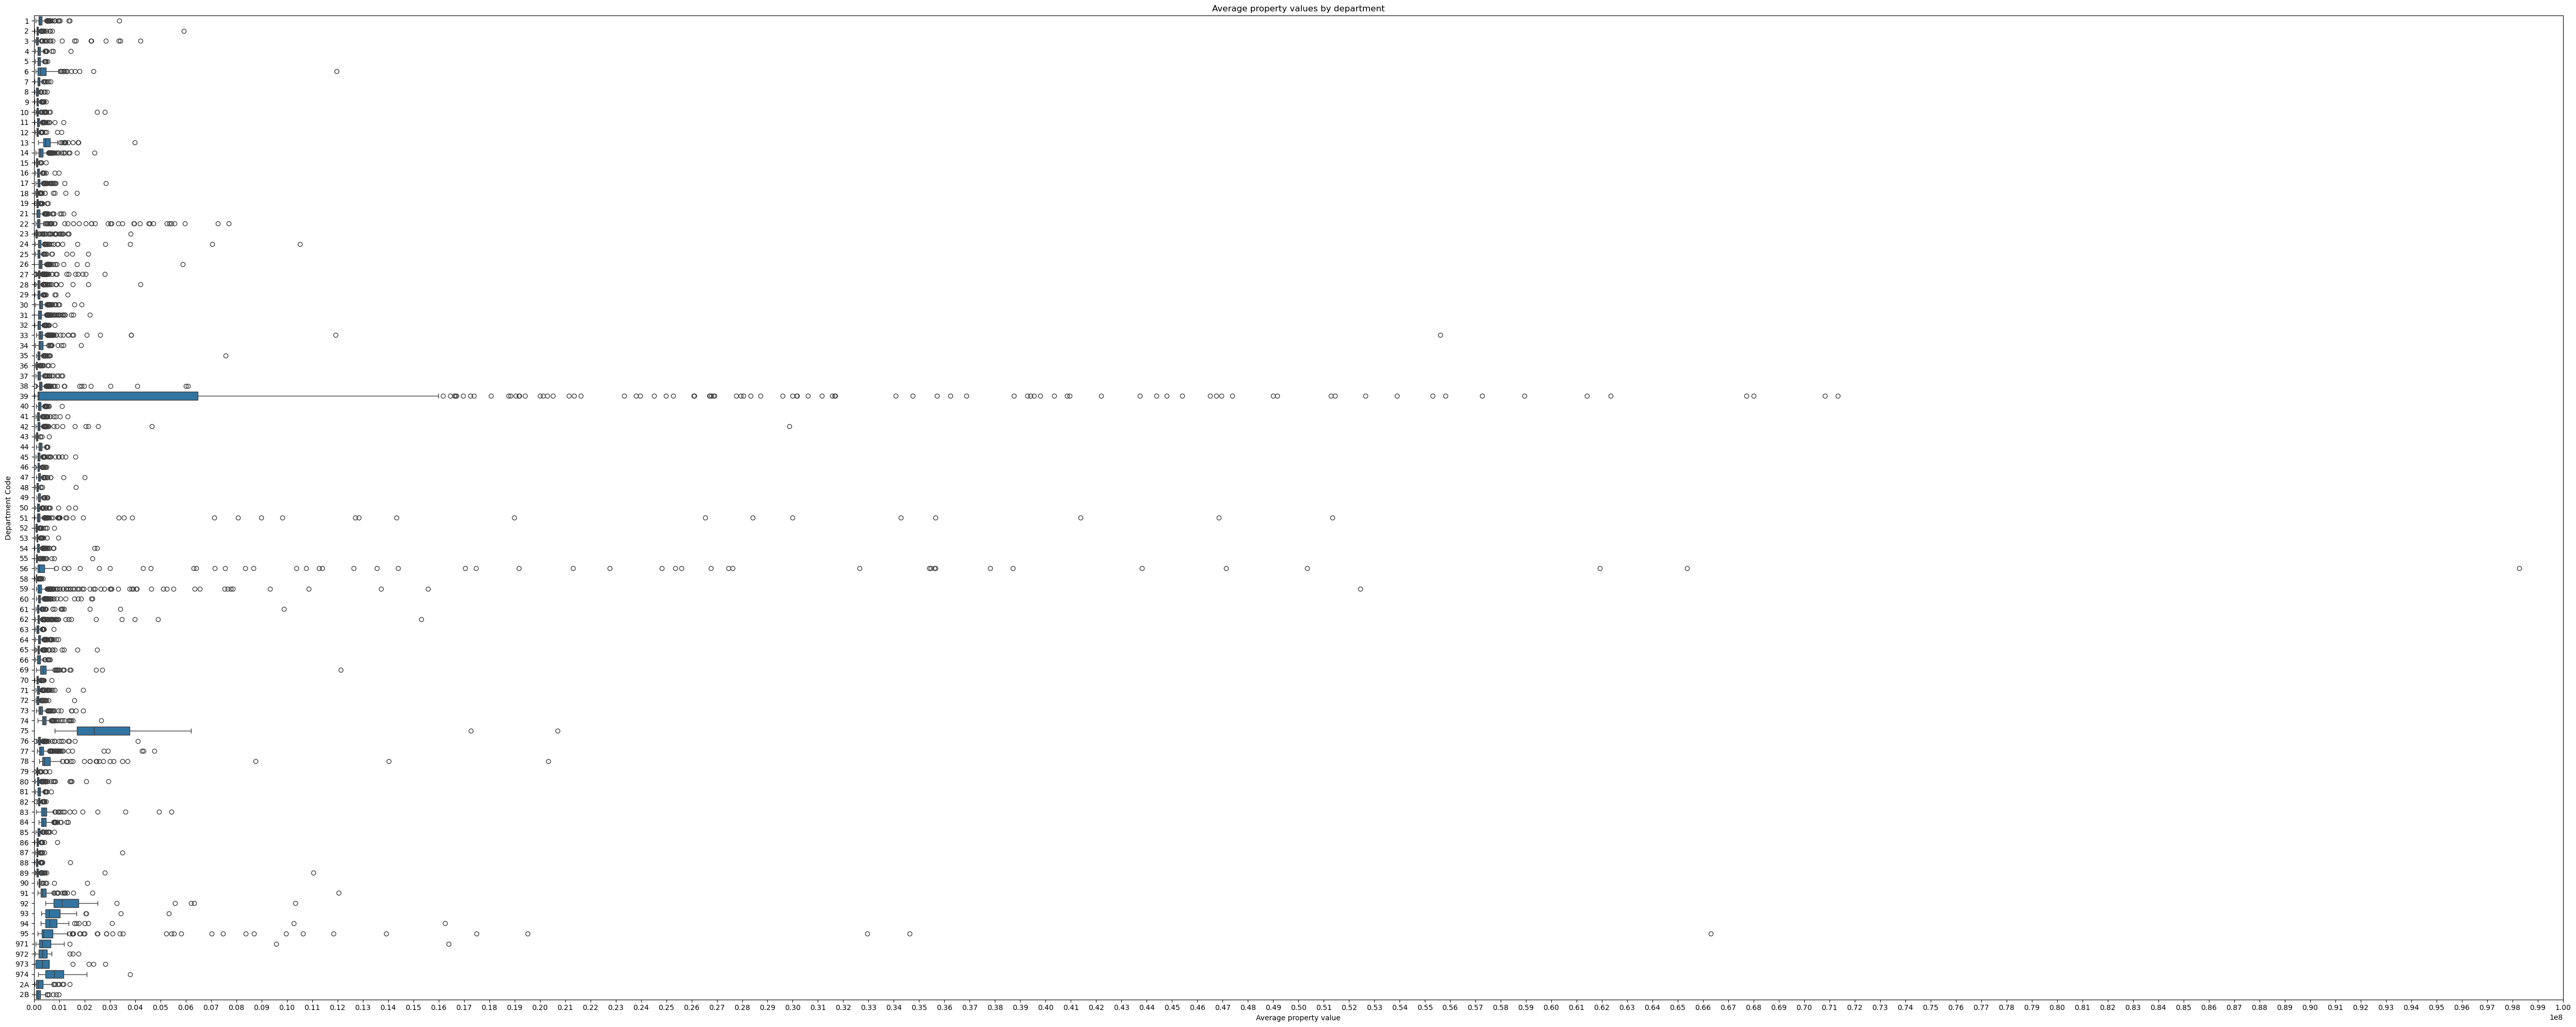

In [17]:
#### IDENTIFY OUTLIERS ####
plt.figure(figsize=(50, 20))
sns.boxplot(data=grouped_geo, x='mean_value', y='Code departement')

plt.title('Average property values by department')
plt.xlabel('Average property value')
plt.ylabel('Department Code')
x_ticks = np.arange(0, grouped_geo['mean_value'].max(), step=1000000)
plt.xticks(x_ticks)
plt.xlim(-10, 100000000)
#plt.yticks(range(start, end, step))
#plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

There are a lot of outliers , this can be explained because of the type of local sold, the year they were sold (inflation ?), their size or their localization. Let's analyze that.

In [18]:
#### SEPARATE OUTLIERS WITH IQR ####
Q1 = df_geo['Valeur fonciere'].quantile(0.25)
Q3 = df_geo['Valeur fonciere'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_geo[(df_geo['Valeur fonciere'] < lower_bound) | (df_geo['Valeur fonciere'] > upper_bound)]
non_outliers = df_geo[(df_geo['Valeur fonciere'] >= lower_bound) & (df_geo['Valeur fonciere'] <= upper_bound)]

outliers.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,price_per_sq_meter
117,2019-03-07 00:00:00.000000000,Vente,3000000.0,MARECHAL JUIN,1000.0,BOURG-EN-BRESSE,1,53,0,4.0,Local industriel. commercial ou assimilé,2465.0,0.0,5926.0,2019,1217.04
1813,2019-08-14 08:43:38.181818112,Vente,644100.0,DU PLAN D'EAU,1370.0,VAL-REVERMONT,1,426,0,4.0,Local industriel. commercial ou assimilé,2191.0,0.0,5247.0,2019,293.98
1814,2019-07-31 10:54:32.727272704,Vente,644100.0,DU PLAN D'EAU,1370.0,VAL-REVERMONT,1,426,0,4.0,Local industriel. commercial ou assimilé,2191.0,0.0,5000.0,2019,293.98
2564,2019-06-11 00:00:00.000000000,Vente,720000.0,DU 1ER SEPTEMBRE 1944,1160.0,PONT-D AIN,1,304,0,4.0,Local industriel. commercial ou assimilé,438.0,0.0,273.0,2019,1643.84
2565,2019-07-11 09:36:00.000000000,Vente,720000.0,DU 1ER SEPTEMBRE 1944,1160.0,PONT-D AIN,1,304,0,4.0,Local industriel. commercial ou assimilé,782.0,0.0,559.0,2019,920.72


We see that a lot of them are commercial or industrial locals which could explain why they are expensive.

In [19]:
#### GROUPING OUTLIERS BY DEPARTMENT AND COMMUNE ####
grouped_outliers = outliers.groupby(['Code departement', 'Commune'], observed=True).agg(
    mean_outliers_value=('Valeur fonciere', 'mean'),
    median_outliers_value=('Valeur fonciere', 'median'),
    sum_outliers_value=('Valeur fonciere', 'sum'),
    count_outliers_transactions=('Valeur fonciere', 'count'),
    outliers_avg_price_per_sq_meter=('price_per_sq_meter', 'mean')
).reset_index()

grouped_outliers.head()

,Code departement,Commune,mean_outliers_value,median_outliers_value,sum_outliers_value,count_outliers_transactions,outliers_avg_price_per_sq_meter
0,1,AMBERIEU-EN-BUGEY,2.362516e+06,1375200.0,148838522.5,63,16678.371429
1,1,AMBERIEUX-EN-DOMBES,1.668587e+06,872600.0,43383255.7,26,23280.409615
2,1,ARBENT,3.174348e+06,2349134.0,57138268.0,18,28574.047222
3,1,ARBOYS EN BUGEY,6.490000e+05,649000.0,649000.0,1,3863.100000
4,1,ARS-SUR-FORMANS,9.918142e+05,1180000.0,12893585.0,13,7796.190769


In [20]:
grouped_outliers.isnull().sum()

Code departement                   0
Commune                            0
mean_outliers_value                0
median_outliers_value              0
sum_outliers_value                 0
count_outliers_transactions        0
outliers_avg_price_per_sq_meter    0
dtype: int64

In [21]:
#### METRICS COMPARISON ####

# All
mean_all = df_geo['Valeur fonciere'].mean()
median_all = df_geo['Valeur fonciere'].median()

# Non-outliers
mean_non_outliers = non_outliers['Valeur fonciere'].mean()
median_non_outliers = non_outliers['Valeur fonciere'].median()

# Outliers
mean_outliers = outliers['Valeur fonciere'].mean()
median_outliers = outliers['Valeur fonciere'].median()

print("General mean :", mean_all)
print("General median :", median_all)
print("\nNon-outliers mean :", mean_non_outliers)
print("Non-outliers median :", median_non_outliers)
print("\nOutliers mean :", mean_outliers)
print("Outliers median :", median_outliers)


General mean : 885459.2904764488
General median : 191900.0

Non-outliers mean : 205565.86862418838
Non-outliers median : 177450.0

Outliers mean : 8005812.542774477
Outliers median : 1070000.0


We see that the general metrics are greatly affected by the outliers, which is why it is necessary to separate them from the rest.

## 3 - Results ##

Presentation of the analyses, visualizations, and findings.

Visualizations:
- Interactive maps of property values by department/commune.
- Bar charts or heatmaps comparing average prices by region.

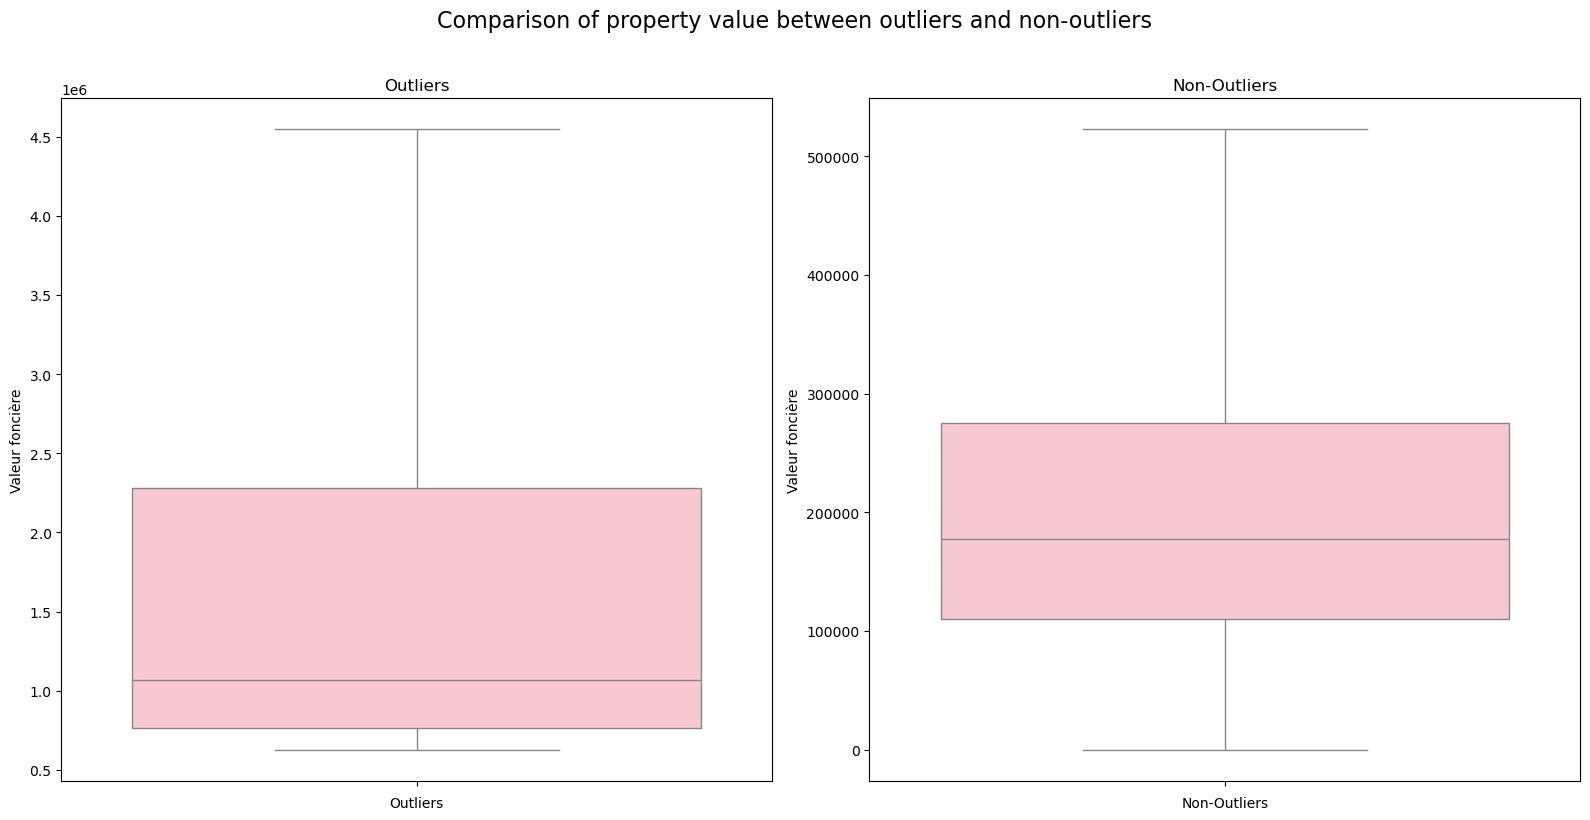

In [38]:
#### COMPARISON BW OUTLIERS AND NON-OUTLIERS ####
plt.figure(figsize=(16, 8))
plt.suptitle("Comparison of property value between outliers and non-outliers", fontsize=16, y=1.02)

# Outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=outliers['Valeur fonciere'], color='pink', showfliers=False)
plt.title('Outliers')
plt.ylabel('Valeur foncière')
plt.xlabel('Outliers')

# Non-outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=non_outliers['Valeur fonciere'], color='pink', showfliers=False)
plt.title('Non-Outliers')
plt.ylabel('Valeur foncière')
plt.xlabel('Non-Outliers')

plt.tight_layout()
plt.show()


We see that the outliers start at 500 000€, exactly where the non outliers stop, and they go up to 4 500 000€.

In [23]:
#### TYPE LOCAL COMPARISON BW OUTLIERS AND NON-OUTLIERS ####

colors = px.colors.qualitative.Pastel

# Count type local
outliers_tl_count = outliers['Type local'].value_counts()
non_outliers_tl_count = non_outliers['Type local'].value_counts()

# Subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Outliers", "Non-Outliers"),
    specs=[[{"type": "pie"}, {"type": "pie"}]]
)

# Outliers
fig.add_trace(
    go.Pie(
    labels = outliers_tl_count.index,
    values = outliers_tl_count,
    name = 'Type local',
    marker = dict(colors = colors),
    ),
    row=1, col=1
)

# Non-outliers
fig.add_trace(
    go.Pie(
        labels = non_outliers_tl_count.index,
        values = non_outliers_tl_count,
        name = 'Type local',
        marker = dict(colors = colors),
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Comparison of local types between outliers and non-outliers",
    showlegend=True
)
fig.show()

We can see that the majority of local types are appartments then houses for both but for the outliers, the portion of industrial local is greater than for non outliers.

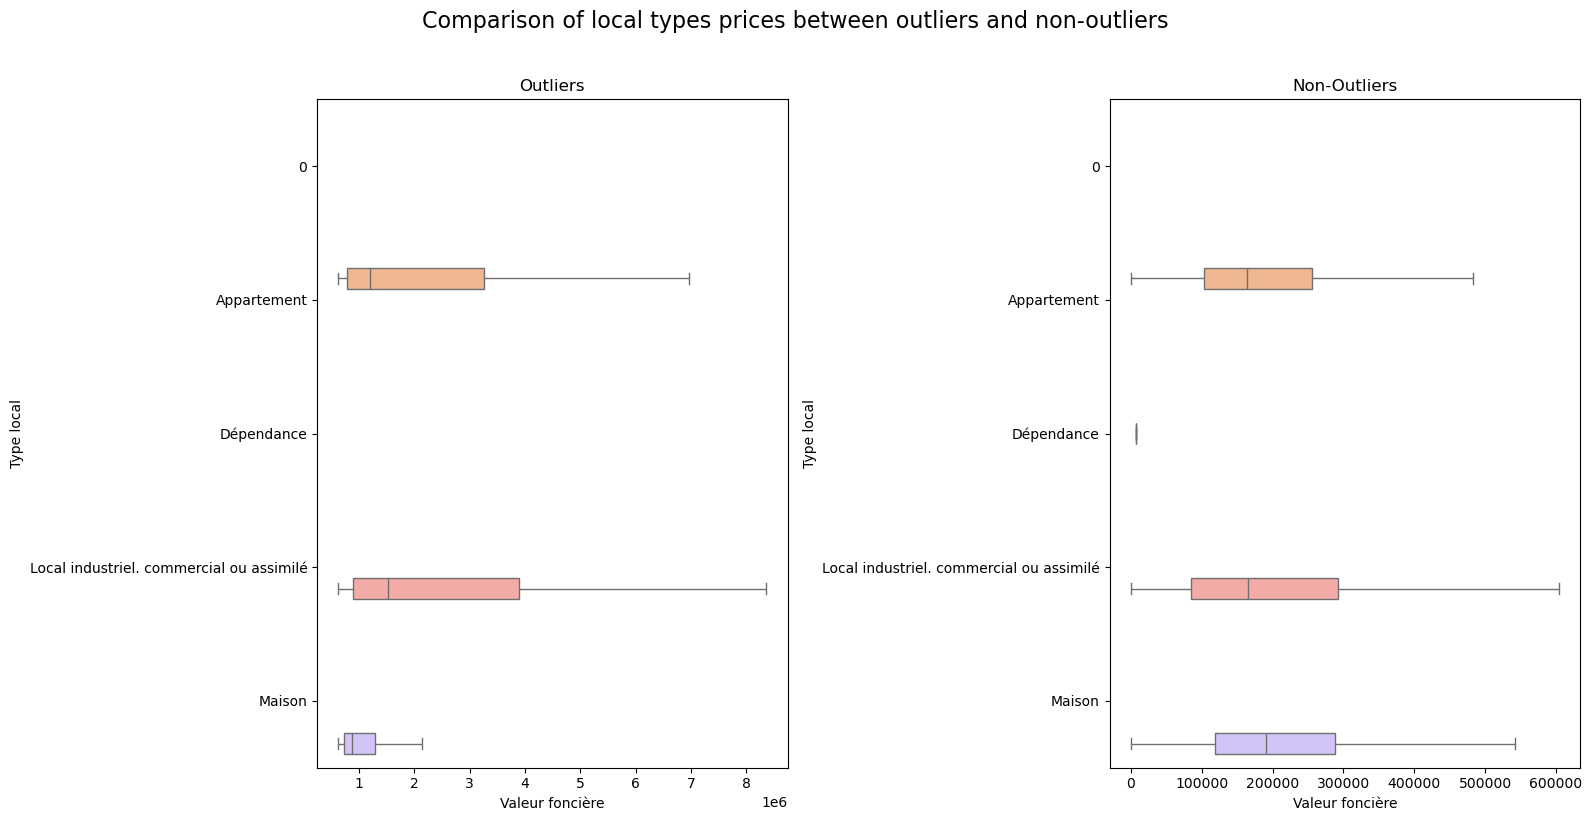

In [29]:
#### COMPARISON BW OUTLIERS AND NON-OUTLIERS ####
plt.figure(figsize=(16, 8))
plt.suptitle("Comparison of local types prices between outliers and non-outliers", fontsize=16, y=1.02)

# Outliers
plt.subplot(1, 2, 1)
sns.boxplot(x='Valeur fonciere', y='Type local', data=outliers, hue='Type local', palette='pastel', showfliers=False, dodge='False')
plt.title('Outliers')
plt.ylabel('Type local')
plt.xlabel('Valeur foncière')

# Non-outliers
plt.subplot(1, 2, 2)
sns.boxplot(x='Valeur fonciere', y='Type local', data=non_outliers, hue='Type local', palette='pastel', showfliers=False, dodge='False')
plt.title('Non-Outliers')
plt.ylabel('Type local')
plt.xlabel('Valeur foncière')

plt.tight_layout()
plt.show()


We can see that the proce range for apartments are from 1M€ to 7M€ for outliers and only up to 450 000€ for non-outliers.

Now let's try to wee where these outliers are located.

Run interactive_maps_geo.ipynb to see maps of the price per square meter by departments depennding of if they're outliers or not.

Now let's study the number of sales per year per departements.

## 4 - Conlusion and recommandations ##

Summary of discoveries and investment advice.

Conclusions:
- Identify regions with the highest or lowest property values.
- Spot any geographical anomalies in property prices.

Recommendations :
- Investment advice based on regions with strong growth or attractive prices.
- Suggestions on how to leverage geographical trends for better returns.